# RFM

In [1]:
import pandas as pd
import sklearn.metrics as mt
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import scipy.cluster.hierarchy as sch

### Reading the Data Set

In [2]:
data = pd.read_csv("OnlineRetail.csv",  sep = ',',encoding = "ISO-8859-1", header= 0)
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], format = "%d-%m-%Y %H:%M")
data.columns.tolist()

['InvoiceNo',
 'StockCode',
 'Description',
 'Quantity',
 'InvoiceDate',
 'UnitPrice',
 'CustomerID',
 'Country']

In [3]:
print("NUMBER OF CUSTOMERS : ",len(pd.unique(data["CustomerID"])))

NUMBER OF CUSTOMERS :  4373


### Data quality check and cleaning

In [4]:

data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
data.shape
data.describe()
data.info()
data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


(541909, 8)

In [6]:
data.isnull().values.any()


True

In [7]:
data.isnull().values.sum()


136534

In [8]:
data.isnull().sum()*100/data.shape[0]

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

In [9]:
data.dropna( inplace=True)

In [10]:
data.shape
data.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

### Extracting R(Recency), F(Frequency), M(Monetary) Attributes

In [11]:
monetary  = pd.DataFrame(data.Quantity * data.UnitPrice, columns = ["Monetary"])
monetary.head()

,Monetary
0,15.30
1,20.34
2,22.00
3,20.34
4,20.34


#### Monetary Value

In [12]:
data = pd.concat(objs = [data, monetary], axis = 1, ignore_index = False)

# Finding total amount spent per customer
monetary = data.groupby("CustomerID").Monetary.sum()
monetary = monetary.reset_index()
monetary.head()

,CustomerID,Monetary
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


#### Frequency Value

In [13]:
frequency = data[['CustomerID', 'InvoiceNo']]

In [14]:
k = frequency.groupby("CustomerID").InvoiceNo.count()
k = pd.DataFrame(k)
k = k.reset_index()
k.columns = ["CustomerID", "Frequency"]
k.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


#### Merging Monetary and Frequency attributes

In [15]:
master = monetary.merge(k, on = "CustomerID", how = "inner")
master.head()

,CustomerID,Monetary,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


### Recency Value

In [16]:
recency  = data[['CustomerID','InvoiceDate']]
maximum = max(recency.InvoiceDate)
maximum

Timestamp('2011-12-09 12:50:00')

In [17]:

recency  = data[['CustomerID','InvoiceDate']]


maximum = max(recency.InvoiceDate)

maximum = maximum + pd.DateOffset(days=1)
recency['diff'] = maximum - recency.InvoiceDate
recency.head()

<ipython-input-17-f80f3eafba61>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recency['diff'] = maximum - recency.InvoiceDate


,CustomerID,InvoiceDate,diff
0,17850.0,2010-12-01 08:26:00,374 days 04:24:00
1,17850.0,2010-12-01 08:26:00,374 days 04:24:00
2,17850.0,2010-12-01 08:26:00,374 days 04:24:00
3,17850.0,2010-12-01 08:26:00,374 days 04:24:00
4,17850.0,2010-12-01 08:26:00,374 days 04:24:00


In [18]:
a = recency.groupby('CustomerID')

In [19]:
a['diff'].min()

CustomerID
12346.0   326 days 02:33:00
12347.0     2 days 20:58:00
12348.0    75 days 23:37:00
12349.0    19 days 02:59:00
12350.0   310 days 20:49:00
                 ...       
18280.0   278 days 02:58:00
18281.0   181 days 01:57:00
18282.0     8 days 01:07:00
18283.0     4 days 00:48:00
18287.0    43 days 03:21:00
Name: diff, Length: 4372, dtype: timedelta64[ns]

In [20]:
#Dataframe merging by recency
df = pd.DataFrame(recency.groupby('CustomerID')['diff'].min())
df = df.reset_index()
df.columns = ["CustomerID", "Recency"]
df.head()

,CustomerID,Recency
0,12346.0,326 days 02:33:00
1,12347.0,2 days 20:58:00
2,12348.0,75 days 23:37:00
3,12349.0,19 days 02:59:00
4,12350.0,310 days 20:49:00


### RFM combined DataFrame

In [21]:
RFM = k.merge(monetary, on = "CustomerID")
RFM = RFM.merge(df, on = "CustomerID")
RFM.head()

,CustomerID,Frequency,Monetary,Recency
0,12346.0,2,0.00,326 days 02:33:00
1,12347.0,182,4310.00,2 days 20:58:00
2,12348.0,31,1797.24,75 days 23:37:00
3,12349.0,73,1757.55,19 days 02:59:00
4,12350.0,17,334.40,310 days 20:49:00


### Outlier Treatment

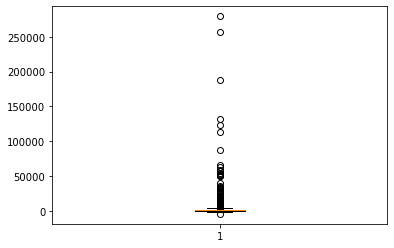

In [22]:
# outlier treatment for Amount
plt.boxplot(RFM.Monetary)
Q1 = RFM.Monetary.quantile(0.25)
Q3 = RFM.Monetary.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Monetary >= (Q1 - 1.5*IQR)) & (RFM.Monetary <= (Q3 + 1.5*IQR))]

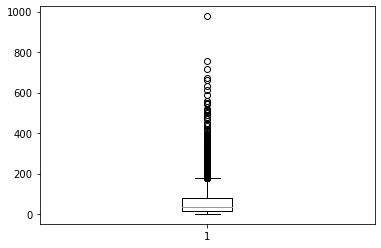

In [23]:
# outlier treatment for Frequency
plt.boxplot(RFM.Frequency)
Q1 = RFM.Frequency.quantile(0.25)
Q3 = RFM.Frequency.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Frequency >= Q1 - 1.5*IQR) & (RFM.Frequency <= Q3 + 1.5*IQR)]

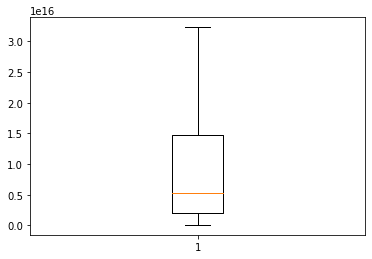

In [24]:
# outlier treatment for Recency
plt.boxplot(RFM.Recency)
Q1 = RFM.Recency.quantile(0.25)
Q3 = RFM.Recency.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Recency >= Q1 - 1.5*IQR) & (RFM.Recency <= Q3 + 1.5*IQR)]

In [25]:
RFM.head(20)


,CustomerID,Frequency,Monetary,Recency
0,12346.0,2,0.00,326 days 02:33:00
2,12348.0,31,1797.24,75 days 23:37:00
3,12349.0,73,1757.55,19 days 02:59:00
4,12350.0,17,334.40,310 days 20:49:00
5,12352.0,95,1545.41,36 days 22:13:00
6,12353.0,4,89.00,204 days 19:03:00
7,12354.0,58,1079.40,232 days 23:39:00
8,12355.0,13,459.40,214 days 23:01:00
9,12356.0,59,2811.43,23 days 04:10:00
11,12358.0,19,1168.06,2 days 02:24:00


### Scaling the RFM data

In [26]:
RFM_norm = RFM.drop(["CustomerID"], axis=1)
RFM_norm.Recency = RFM_norm.Recency.dt.days

from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
RFM_norm = standard_scaler.fit_transform(RFM_norm)

In [27]:
RFM_norm = pd.DataFrame(RFM_norm)
RFM_norm.columns = ['Frequency','Amount','Recency']
RFM_norm.head()

,Frequency,Amount,Recency
0,-1.070949,-1.041614,2.136422
1,-0.375498,1.385298,-0.282050
2,0.631707,1.331702,-0.821629
3,-0.711233,-0.590055,1.982257
4,1.159290,1.045238,-0.657828


<hr>

# IMPLEMENTING KMEANS ALGORITHM

Calculating K value using Silhouette scores

In [28]:
from sklearn.metrics import silhouette_score
ss = []
for k in range(4, 15):
    kmeans = KMeans(n_clusters=k).fit(RFM_norm)
    ss.append([k, silhouette_score(RFM_norm, kmeans.labels_)])
ss

[[4, 0.40851721359807264],
 [5, 0.3891371946885664],
 [6, 0.3573383757831959],
 [7, 0.33216620426438326],
 [8, 0.3411446855523718],
 [9, 0.34938978619546823],
 [10, 0.3161008824353734],
 [11, 0.3230037134134392],
 [12, 0.3041143930467548],
 [13, 0.29461254046615776],
 [14, 0.3112968499328308]]

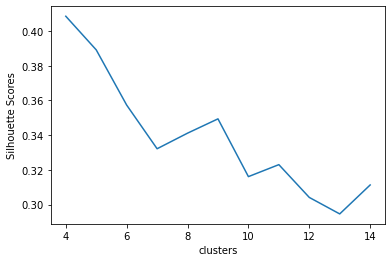

In [29]:
plt.xlabel("clusters")
plt.ylabel("Silhouette Scores")
plt.plot(pd.DataFrame(ss)[0], pd.DataFrame(ss)[1]);

Calculating K value using Inertia

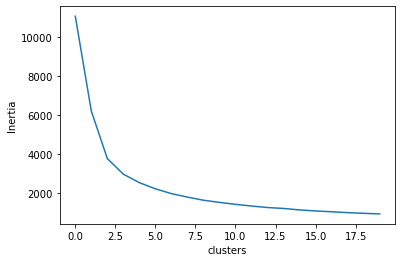

In [30]:
inertia = []
for num_clusters in list(range(1,21)):
    model_clus = KMeans(n_clusters = num_clusters, max_iter=50)
    model_clus.fit(RFM_norm)
    inertia.append(model_clus.inertia_)
plt.xlabel("clusters")
plt.ylabel("Inertia")
plt.plot(inertia)

In [31]:
kmeans_model = KMeans(n_clusters=4, init='k-means++', random_state=42)
y_kmeans = kmeans_model.fit_predict(RFM_norm)
X = np.array(RFM_norm)

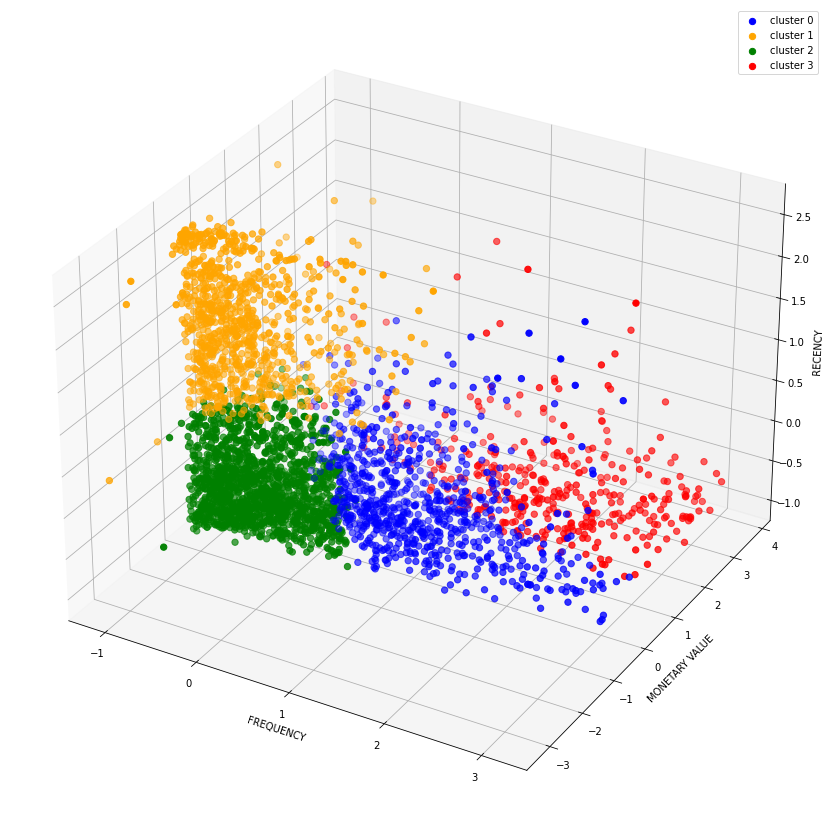

In [32]:
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[y_kmeans == 0,0],X[y_kmeans == 0,1],X[y_kmeans == 0,2], s = 40 , color = 'blue', label = "cluster 0")
ax.scatter(X[y_kmeans == 1,0],X[y_kmeans == 1,1],X[y_kmeans == 1,2], s = 40 , color = 'orange', label = "cluster 1")
ax.scatter(X[y_kmeans == 2,0],X[y_kmeans == 2,1],X[y_kmeans == 2,2], s = 40 , color = 'green', label = "cluster 2")
ax.scatter(X[y_kmeans == 3,0],X[y_kmeans == 3,1],X[y_kmeans == 3,2], s = 40 , color = 'red', label = "cluster 3")

ax.set_xlabel('FREQUENCY')
ax.set_ylabel('MONETARY VALUE')
ax.set_zlabel('RECENCY')
ax.legend()
plt.show()

In [33]:
np.unique(y_kmeans)

array([0, 1, 2, 3])

In [34]:
RFM_km = pd.concat([RFM, pd.Series(y_kmeans)], axis=1)
RFM_km.columns = ['CustomerID', 'Frequency', 'Monetary', 'Recency', 'ClusterID']

RFM_km.Recency = RFM_km.Recency.dt.days
km_clusters_monetary = pd.DataFrame(RFM_km.groupby(["ClusterID"]).Monetary.mean())
km_clusters_frequency = pd.DataFrame(RFM_km.groupby(["ClusterID"]).Frequency.mean())
km_clusters_recency = pd.DataFrame(RFM_km.groupby(["ClusterID"]).Recency.mean())
RFM_km.head()

,CustomerID,Frequency,Monetary,Recency,ClusterID
0,12346.0,2.0,0.00,326.0,1.0
1,NaN,NaN,NaN,NaN,0.0
2,12348.0,31.0,1797.24,75.0,0.0
3,12349.0,73.0,1757.55,19.0,1.0
4,12350.0,17.0,334.40,310.0,0.0


# AGGLOMERATIVE CLUSTERING

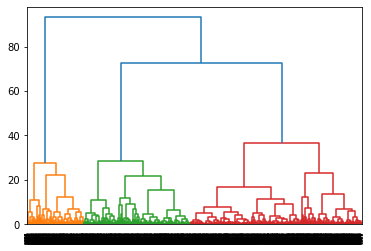

In [35]:
dendrogram = sch.dendrogram(sch.linkage(RFM_norm, method='ward'))

In [36]:
from sklearn.cluster import AgglomerativeClustering
import sklearn.metrics as mt
arr = []
X = RFM_norm
print("K            SILHOUETTE SCORE")
print(end="\n")
for i in range(4,11):
  model = AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage='ward')
  agg=model.fit(X)
  print(i,"        ",mt.silhouette_score(X, agg.labels_, metric='euclidean'))
  arr.append(mt.silhouette_score(X, agg.labels_, metric='euclidean'))

K            SILHOUETTE SCORE

4          0.3249143321884565
5          0.28975162027039275
6          0.28733101826072266
7          0.2850454549109047
8          0.29746937326162537
9          0.3052872562565845
10          0.25424600757910637


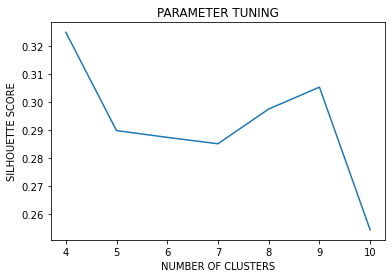

In [37]:
plt.plot(range(4,11), arr)
plt.title('PARAMETER TUNING')
plt.xlabel('NUMBER OF CLUSTERS')
plt.ylabel('SILHOUETTE SCORE')
plt.show()

In [38]:
model = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
agg=model.fit_predict(RFM_norm)
agg

array([0, 2, 1, ..., 0, 3, 1], dtype=int64)

<Figure size 432x288 with 0 Axes>

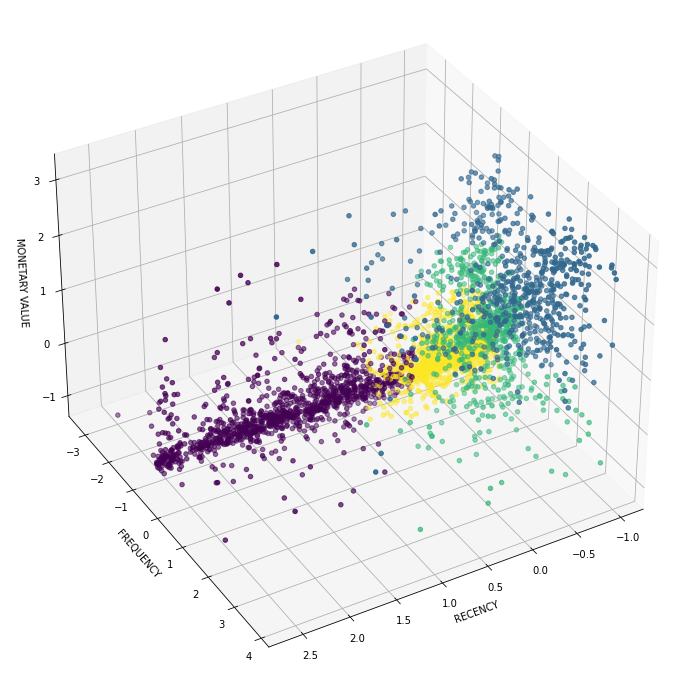

In [39]:
fig = plt.figure()
fig=plt.figure(figsize=(12,90))
ax = plt.axes(projection='3d')
xline=RFM_norm['Recency']
yline=RFM_norm['Frequency']
zline=RFM_norm['Amount']
plt.xlabel("RECENCY")
plt.ylabel("FREQUENCY")
ax.set_zlabel('MONETARY VALUE')
ax.scatter3D(xline, zline,yline,c=agg)
ax.view_init(35,60)

# DBSCAN

In [40]:
from sklearn.neighbors import NearestNeighbors

In [41]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(RFM_norm)
distances, indices = nbrs.kneighbors(RFM_norm)

array([1.35035492e-04, 1.35035492e-04, 1.01276619e-03, ...,
       1.10735719e+00, 1.12508508e+00, 1.12508508e+00])

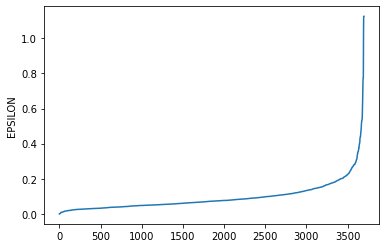

In [42]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.ylabel("EPSILON")
plt.plot(distances)
distances

In [43]:
dbsc = DBSCAN(eps = 0.21, min_samples = 20).fit(RFM_norm)
dbs=dbsc.fit_predict(RFM_norm)


In [44]:
# RFM_norm1['cluster_pred']
np.unique(dbs)


array([-1,  0], dtype=int64)

In [45]:
mt.silhouette_score(RFM_norm, dbs, metric='euclidean')

0.2692400279336455

<Figure size 432x288 with 0 Axes>

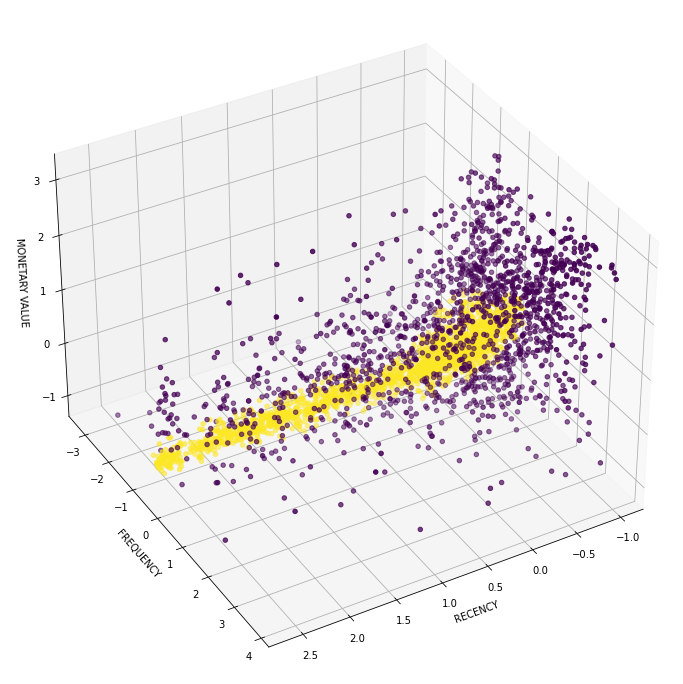

In [70]:
fig = plt.figure()
fig=plt.figure(figsize=(12,90))
ax = plt.axes(projection='3d')
xline=RFM_norm['Recency']
yline=RFM_norm['Frequency']
zline=RFM_norm['Amount']
plt.xlabel('RECENCY')
plt.ylabel('FREQUENCY')
ax.set_zlabel('MONETARY VALUE')
ax.scatter3D(xline, zline,yline,c=dbs)
ax.view_init(35,60)

In [47]:
RFM_db = pd.concat([RFM, pd.Series(dbs)], axis=1)
RFM_db.columns = ['CustomerID', 'Frequency', 'Amount', 'Recency', 'ClusterID']

RFM_db.Recency = RFM_db.Recency.dt.days
db_clusters_amount = pd.DataFrame(RFM_db.groupby(["ClusterID"]).Amount.mean())
db_clusters_frequency = pd.DataFrame(RFM_db.groupby(["ClusterID"]).Frequency.mean())
db_clusters_recency = pd.DataFrame(RFM_db.groupby(["ClusterID"]).Recency.mean())

In [48]:
db_clusters_amount.reset_index(inplace=True)
db_clusters_frequency.reset_index(inplace=True)
db_clusters_recency.reset_index(inplace=True)

In [49]:
db_clusters_amount=db_clusters_amount.drop('ClusterID', axis=1)

In [50]:
db_clusters_frequency=db_clusters_frequency.drop('ClusterID', axis=1)

In [51]:
db_clusters_recency=db_clusters_recency.drop('ClusterID', axis=1)


In [52]:
np.unique(dbs)

array([-1,  0], dtype=int64)

In [53]:
dfdb = pd.concat([pd.Series(np.unique(dbs)), db_clusters_amount, db_clusters_frequency, db_clusters_recency], axis=1)
dfdb.columns = ["ClusterID", "Amount_mean", "Frequency_mean", "Recency_mean"]
dfdb 

,ClusterID,Amount_mean,Frequency_mean,Recency_mean
0,-1,777.161871,47.977831,105.005542
1,0,787.437086,46.465378,102.395598


In [54]:
from sklearn.cluster import MeanShift

ms = MeanShift(bandwidth=1.15)
msh = ms.fit_predict(RFM_norm)
np.unique(msh)

array([0, 1, 2, 3], dtype=int64)

In [55]:
mt.silhouette_score(RFM_norm, msh, metric='euclidean')

0.3815295751174985

<Figure size 432x288 with 0 Axes>

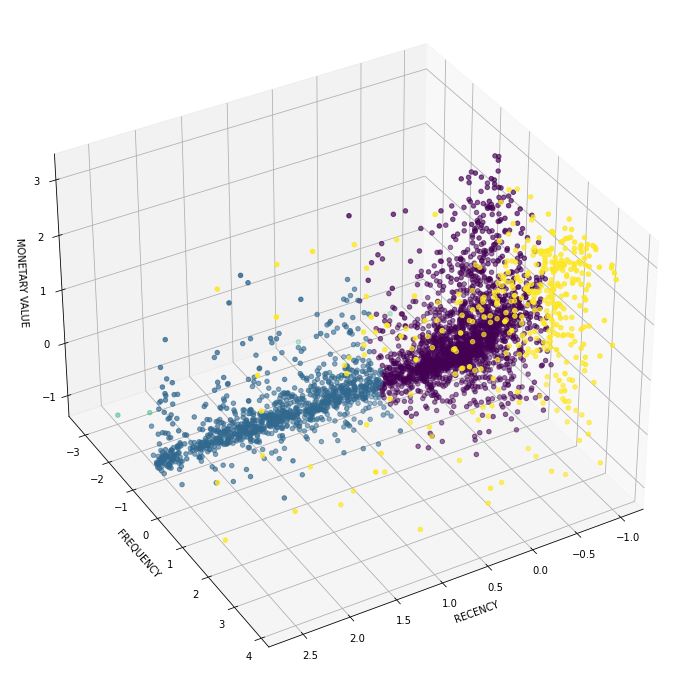

In [56]:
fig = plt.figure()
fig=plt.figure(figsize=(12,90))
ax = plt.axes(projection='3d')
xline=RFM_norm['Recency']
yline=RFM_norm['Frequency']
zline=RFM_norm['Amount']
plt.xlabel('RECENCY')
plt.ylabel('FREQUENCY')
ax.set_zlabel('MONETARY VALUE')
ax.scatter3D(xline, zline,yline,c=msh)
ax.view_init(35,60)

# Comparing the Models using Silhouette scores

For K means:

In [57]:
y=[]
y.append(mt.silhouette_score(RFM_norm, y_kmeans, metric='euclidean'))

For Agglomerative Model:

In [58]:
y.append(mt.silhouette_score(RFM_norm, agg, metric='euclidean'))

For DBSCAN:

In [59]:
y.append(mt.silhouette_score(RFM_norm, dbs, metric='euclidean'))

For MeanShift:

In [60]:
y.append(mt.silhouette_score(RFM_norm, msh, metric='euclidean'))

<BarContainer object of 4 artists>

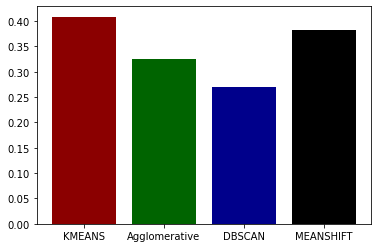

In [61]:
x=['KMEANS', 'Agglomerative', 'DBSCAN', 'MEANSHIFT']

plt.bar(x,y,color=('darkred','darkgreen', 'darkblue','black'))

# K MEANS

In [62]:
RFM.index = pd.RangeIndex(len(RFM.index))
RFM_km = pd.concat([RFM, pd.Series(y_kmeans)], axis=1)
RFM_km.columns = ['CustomerID', 'Frequency', 'Monetary', 'Recency', 'ClusterID']

RFM_km.Recency = RFM_km.Recency.dt.days
km_clusters_monetary = pd.DataFrame(RFM_km.groupby(["ClusterID"]).Monetary.mean())
km_clusters_frequency = pd.DataFrame(RFM_km.groupby(["ClusterID"]).Frequency.mean())
km_clusters_recency = pd.DataFrame(RFM_km.groupby(["ClusterID"]).Recency.mean())

**Mean values of Monetary in each cluster**

In [63]:
km_clusters_monetary

,Monetary
ClusterID,
0,1107.920857
1,328.084409
2,446.946652
3,2464.467410


**Mean values of Frequency in each cluster**

In [64]:
km_clusters_frequency

,Frequency
ClusterID,
0,84.268116
1,20.451613
2,25.162076
3,117.521164


**Mean values of Recency in each cluster**

In [65]:
km_clusters_recency

,Recency
ClusterID,
0,51.028986
1,260.143011
2,55.582960
3,38.478836


In [66]:
df = pd.concat([pd.Series([0,1,2,3]), km_clusters_monetary, km_clusters_frequency, km_clusters_recency], axis=1)
df.columns = ["ClusterID", "Amount_mean", "Frequency_mean", "Recency_mean"]
df

,ClusterID,Amount_mean,Frequency_mean,Recency_mean
0,0,1107.920857,84.268116,51.028986
1,1,328.084409,20.451613,260.143011
2,2,446.946652,25.162076,55.582960
3,3,2464.467410,117.521164,38.478836


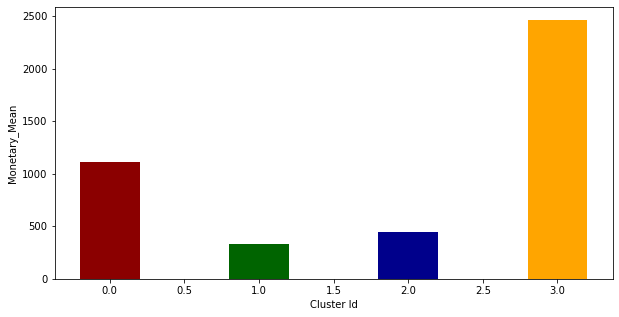

In [67]:
# sns.barplot(x=df.ClusterID, y=df.Amount_mean)

fig = plt.figure(figsize = (10, 5))
plt.bar(df.ClusterID,df.Amount_mean, color =('darkred','darkgreen','darkblue','orange'), width = 0.4)
plt.xlabel("Cluster Id")
plt.ylabel("Monetary_Mean")
plt.show()

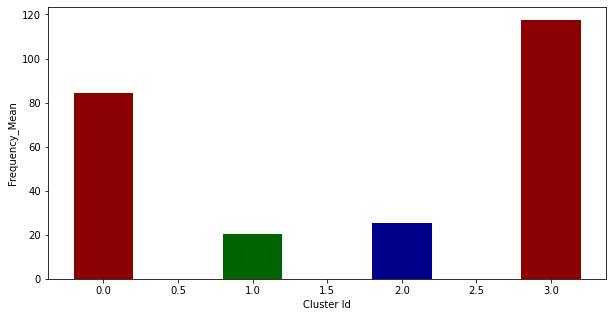

In [68]:
# sns.barplot(x=df.ClusterID, y=df.Frequency_mean)
fig = plt.figure(figsize = (10, 5))
plt.bar(df.ClusterID,df.Frequency_mean, color =('darkred','darkgreen','darkblue'), width = 0.4)
plt.xlabel("Cluster Id")
plt.ylabel("Frequency_Mean")
plt.show()

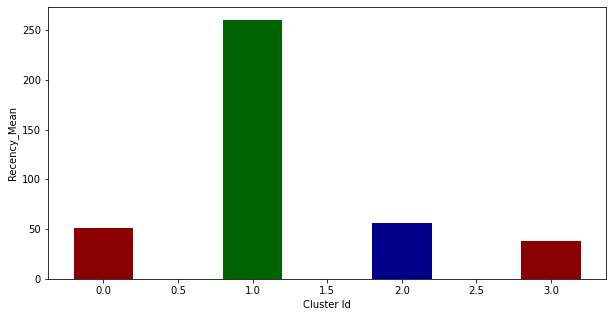

In [69]:
# sns.barplot(x=df.ClusterID, y=df.Recency_mean)
fig = plt.figure(figsize = (10, 5))
plt.bar(df.ClusterID,df.Recency_mean, color =('darkred','darkgreen','darkblue'), width = 0.4)
plt.xlabel("Cluster Id")
plt.ylabel("Recency_Mean")
plt.show()

<hr>

DESCRIPTION:

CLUSTER 0 : Moderate Monetary value, High Frequency value, Low Recency value - GOOD VALUE LOYAL CUSTOMERS
CLUSTER 1 : Low Monetary value, Low Frequency value, High Recency value - LOST UNSATISFIED CUSTOMERS
CLUSTER 2 : Low Monetary value,Low Frequency value, Low Recency value - UNSATISFIED CUSTOMERS
CLUSTER 3 : High Monetary value, High Frequency Value, Low Recency Value - BEST VALUE CUSTOMERS
